In [6]:
using pulse_input_DDM
using Random, Distributions
using Parameters, PyPlot

In [ ]:
θ, options, params = create_θ("expfilter");

In [ ]:
ntrials= 10
dt = 1e-4
dx = 0.1
rng = 1
centered = false
data = synthetic_data(θ, dt, ntrials);
data_dict = pulse_input_DDM.make_data_dict(data)


In [ ]:
RT = map(data -> data.click_data.clicks.T, data)
gamma = map(data -> data.click_data.clicks.gamma, data)
pokedR = map(data -> data.choice, data)
correct = gamma .> 0 
hits = pokedR .== correct
ugam = sort(unique(gamma))

fracR = [mean(pokedR[gamma .== i]) for i in ugam]
hitRT = [mean(RT[(gamma .== i) .& hits .== 1]) for i in ugam]
errRT = [mean(RT[(gamma .== i) .& .~hits .== 1]) for i in ugam]

In [ ]:
plot(ugam, fracR)

In [ ]:
plot(ugam, hitRT)
plot(ugam, errRT)

In [ ]:
optimize(data, data_dict,"Qlearn", options, 0.2, iterations=5)

In [ ]:
pulse_input_DDM.loglikelihood(θ, data, data_dict, dx)

In [ ]:
1e1

In [ ]:
using pulse_input_DDM
using Parameters
using Random
using PyPlot
using Distributions 

θ, options, prms= create_θ("expfilter")

In [ ]:
data = synthetic_data(θ, 1e-2, 10)

In [ ]:
file = "sess_rawdata_X017.mat"
data, data_dict = load("sess_rawdata_X017.mat", dt = 1e-2)

In [ ]:
dx = 0.02
modeltype = "expfilter"
θ, options, prms = create_θ(modeltype)

In [ ]:
# initial point computation
a_0 = compute_initial_pt(θ.hist_θz, θ.base_θz.σ2_s, data_dict)  

# non-decision time distribution computation
@unpack ndtimeL1, ndtimeL2 = θ.ndtime_θz
@unpack ndtimeR1, ndtimeR2 = θ.ndtime_θz
NDdistL = Gamma(ndtimeL1, ndtimeL2)
NDdistR = Gamma(ndtimeR1, ndtimeR2)

dt = data_dict["dt"]
frac = data_dict["frac"]

# get mean and variance for log posterior space
if θ.lpost_space == 1
    σ2_s, C = pulse_input_DDM.transform_log_space(data_dict["teps"], θ.base_θz.σ2_s) 
else
    σ2_s = θ.base_θz.σ2_s
    C = "undef" 
end

penalty = pulse_input_DDM.constraint_penalty(θ.hist_θz, data_dict["ntrials"], mean(data_dict["lapse_lik"]))

P = map((data, a_0, nT) -> pulse_input_DDM.loglikelihood!(θ.base_θz, data, σ2_s, C, a_0, dx, pdf.(NDdistL, dt.*collect(nT:-1:1)).*dt, 
                                    pdf.(NDdistR, dt.*collect(nT:-1:1)).*dt), data, a_0, data_dict["nT"])

sum(log.((frac .* data_dict["lapse_lik"] .* .5) .+ 
        (1. - frac).*map((P, choice) -> (choice ? P[2] : P[1]), P, data_dict["choice"])))
    + penalty

In [ ]:
model, output, ll = optimize(data, data_dict, modeltype, options, dx)

In [ ]:
model = choiceDDM(θ, data)
ll = pulse_input_DDM.loglikelihood(θ, data, data_dict, dx)

In [1]:
using pulse_input_DDM
using Parameters
using PyPlot

┌ Info: Precompiling pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1273


In [2]:
data, data_dict = load("sess_rawdata_X017.mat", dt = 1e-2);
θ, options, params = create_θ("Qlearn");

In [3]:

hist_θz = θz_Qlearn.(0.78, 0.07, 0.87, 0.32, 0.80, 0.312)

θz_Qlearn{Float64}
  h_αr: Float64 0.78
  h_αf: Float64 0.07
  h_κlc: Float64 0.87
  h_κle: Float64 0.32
  h_κrc: Float64 0.8
  h_κre: Float64 0.312


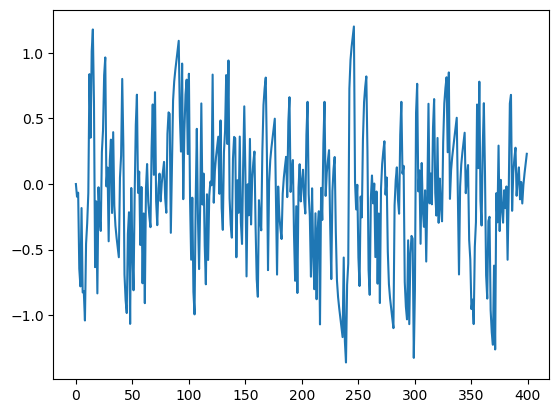

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15c7993d0>

In [4]:
i_0 = compute_initial_pt(hist_θz, 1.5, data_dict);
plot(i_0[1:400])

In [20]:
hist_θz = θz_Qlearn.(0.78, 0.7, 0.87, 0.32, 0.80, 0.312)

θz_Qlearn{Float64}
  h_αr: Float64 0.78
  h_αf: Float64 0.7
  h_κlc: Float64 0.87
  h_κle: Float64 0.32
  h_κrc: Float64 0.8
  h_κre: Float64 0.312


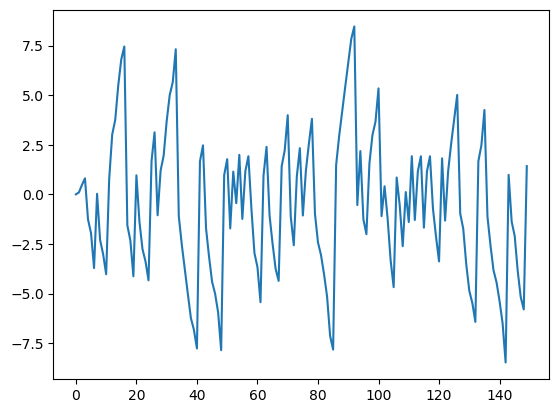

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x163f1a110>

In [21]:
B0 = 2.5
belief = exp(B0)/(1+exp(B0))   # belief
@unpack h_αr, h_αf, h_κlc, h_κle, h_κrc, h_κre = hist_θz

cprob = Array{Float64}(undef, data_dict["ntrials"])
QLL = Array{Float64}(undef, data_dict["ntrials"])
QRR = Array{Float64}(undef, data_dict["ntrials"])

cprob[1] = 1.
Qll, Qrr = 12.,12.
QLL[1] = Qll
QRR[1] = Qrr
for i = 2:data_dict["ntrials"]
    if data_dict["choice"][i-1]   # rightward choice
        data_dict["hits"][i-1] ? outcome = h_κrc : outcome = h_κre
        Qrr = (1-h_αr*belief)*Qrr + h_αr*outcome
        Qll = (1-h_αf)*Qll
    else
        data_dict["hits"][i-1] ? outcome = h_κlc : outcome = h_κle
        Qll = (1-h_αr*belief)*Qll + h_αr*outcome
        Qrr = (1-h_αf)*Qrr
    end
    cprob[i] = Qrr/Qll
    QLL[i] = Qll
    QRR[i] = Qrr
end

pmax =150
plot(log.(cprob[1:pmax]))

In [18]:
beliefL

0.07585818002124356

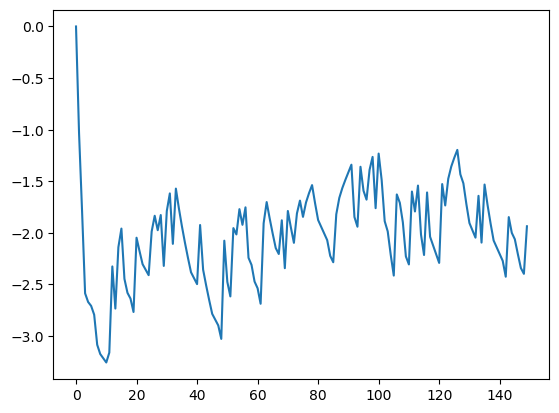

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x163a2dfd0>

In [ ]:
plot(QLL[1:pmax], label = "Q_L")
plot(QRR[1:pmax], label = "Q_R")
legend()

In [ ]:
hist_θz

In [ ]:
# leftward expected q
24*sum((data_dict["hits"] .== 1) .& (data_dict["choice"] .== 0))/(sum(data_dict["choice"] .== 0))

In [ ]:
# rightward expected q
24*sum((data_dict["hits"] .== 1) .& (data_dict["choice"] .== 1))/(sum(data_dict["choice"] .== 1))

In [ ]:
# Fractioon correct trials
sum((data_dict["hits"] .== 1))/data_dict["ntrials"]

In [ ]:
# Fraction rightward trials
sum(data_dict["correct"])/data_dict["ntrials"]

In [ ]:
# Fraction rightward choices
sum(data_dict["choice"])/data_dict["ntrials"]

In [1]:
using pulse_input_DDM

┌ Info: Precompiling pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1273


In [ ]:
θ, options, params = create_θ("expfilter")

In [ ]:
function printam(θ::DDMθch)
    print("yup")
end

printam(θ.hist_θz) 
i = 1

In [ ]:
i = 1            
lim, a_0, rel = i, 0., []


In [ ]:
lim

In [ ]:
chddict = Dict("θz_expfilter_ce{Float64}" => true,
                    "θz_expfilter_ce_bias{Float64}" => true,
                        "θz_Qlearn{Float64}"       => true,
                "θz_expfilter{Float64}" => false)

In [ ]:
get(chddict,"expfilter",true)

In [ ]:
haskey(chddict,"DBMexp")

In [ ]:
typeof(θ.hist_θz)

In [ ]:
get(,chddict,typeof(θ.hist_θz))

In [ ]:
for i = 1:length(chddict)
   ans[i] = typeof(θ.hist_θz) == chddict[i] 
end

In [ ]:
θ.hist_θz isa chddict[1] 


In [ ]:
has(chddict,"θz_expfilter_ce")

In [ ]:
?get